In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup as bs
import os, time, json, requests
from PIL import Image

In [4]:
# 这部分代码是在知网搜索界面搜索并获取搜索结果的信息

def get_string(a_string):
    a_string = ''.join((''.join(a_string.split("<sub>"))).split("</sub>"))   # 删去sub标签
    a = ''.join((''.join(a_string.split("<sup>"))).split("</sup>"))   # 删去sup标签
    return a.split('<')[-2].split('>')[-1].strip()


def check_vericode(driver, j):    # 检验是否需要验证码，需要的话显示验证码图片，并人工输入验证码
    # j 是布尔值，用于判断是否需要改变验证码
    vericode = driver.find_element_by_id('vericode')   # 这个是验证码输入框
    changeVercode = driver.find_element_by_id('changeVercode')    # 这个是验证码图片
    if j:   # 如果 j 是 True，就点击验证码图片，换一个验证码
        changeVercode.click()
    img_path = "./data/vericode.png"
    changeVercode.screenshot(img_path)
    img = Image.open(img_path)
    display(img)    # 展示图片
    input_string = input("请输入验证码：")
    vericode.send_keys(input_string + "\n")
    os.remove(img_path)   # 删掉验证码图片
    time.sleep(10)


def get_page(input_string):   # 获取每一页的源代码
    display = input("是否显示模拟浏览器？(y/n)")   # 默认为yes
    print("开始获取网页源代码步骤")
    html_ls = []   # 获取的HTML源代码全部放在这里
    if display == 'n':
        # 下面这段代码是不让模拟浏览器显示出来的，测试完代码之后启动
        chrome_options = Options()
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--disable-gpu')
        driver = webdriver.Chrome(chrome_options = chrome_options)
    else:
        driver = webdriver.Chrome()
    url = "https://kns.cnki.net/kns8/defaultresult/index"
    driver.get(url)
    txt_search = driver.find_element_by_id('txt_search')
    txt_search.send_keys(input_string + "\n")    # 这个 '\n' 可以直接当回车用，就不用点击了
    time.sleep(10)   # 等一会儿，不然有些信息加载不出来
    html = driver.page_source   # 获取网页源代码
    html_ls.append(html)
    soup = bs(html, "html.parser")
    div = soup.find("div", {"class":"all-box"})
    em = div.find("em")
    print("共 {} 篇文献".format(em.string))   # em.string 包含的是获取的文献总数
    num = (int(em.string) - 1)//20   # 每页有20篇文献，-1是为了20的倍数时别多翻页
    print("\r已完成 {}/{} 页".format(1, num + 1), end = '')
    if num > 0:
        for i in range(num):
            try:
                PageNext = driver.find_element_by_id("PageNext")
                PageNext.click()
                time.sleep(7)
                
                j = False
                while True:   # 这个循环是用于检测验证码的
                    try:
                        vericode = driver.find_element_by_id('vericode')
                    except:
                        break
                    else:
                        check_vericode(driver, j)
                        j = True
                
                html_ls.append(driver.page_source)
                print("\r已完成 {}/{}".format(i + 2, num + 1), end = '')
            except:
                print("\n进展到第 {} 页时出了问题。".format(i+2))

        print("\r获取网页源代码步骤完毕")
    driver.close()
    return html_ls


def get_infos(html):   # 获取所有文献的基本信息，包括文献url, 标题，作者等，尽可能多得获取信息
    soup = bs(html, "html.parser")
    tbody = soup.find("tbody")
    tr_ls = tbody.find_all("tr")
    for j, tr in enumerate(tr_ls):
        tr_dic = {}
        tr_dic["seq"] = get_string(str(tr.find("td", {"class":"seq"})))  # 文献的序号，好像没啥意义，加上再说
        name = tr.find("td", {"class":"name"}).find('a')
        tr_dic["url"] = "https://kns.cnki.net" + name.attrs["href"]   # 文献的url
        try:
            tr_dic["name"] = name.string.strip()   # 文献的名称
        except:
            tr_dic["name"] = get_string(str(name))
        authors = tr.find("td", {"class":"author"}).find_all('a')
        tr_dic["author"] = [a.string for a in authors]     # 作者信息
        source = tr.find("td", {"class":"source"})
        if source.find('a') == None:
            source = source.string.strip()
        else:
            source = source.find('a').string.strip()
        tr_dic["source"] = source   # 文献的来源
        tr_dic["date"] = tr.find("td", {"class":"date"}).string.strip()   # 文献的发表日期
        tr_dic["data"] = tr.find("td", {"class":"data"}).string.strip()   # 文献的来源数据库
        a = tr.find("td", {"class":"quote"}).find('a')
        if a == None:
            num = 0
        else:
            num = int(a.string)
        tr_dic["quote"] = num   # 文献的被引用次数
        with open("./data/info_ls.json", "at", encoding = 'utf-8') as fo:
            fo.write(json.dumps(tr_dic))   # 把数据以json格式备份
            fo.write('\n')
        print("\r已完成 {} 篇".format(tr_dic["seq"]), end = '')
        
        
def main():
    input_string = input("请输入想搜索的关键词：")   # 索引关键词
    start_1 = time.time()
    if not os.path.exists("./data/html_ls.txt"):
        html_ls = get_page(input_string)
        with open("./data/html_ls.txt", "wt", encoding = 'utf-8') as fo:
            fo.write(json.dumps(html_ls))   # 备份数据
    else:
        print("网页信息已存在，直接分析数据")
        with open("./data/html_ls.txt", "rt", encoding = 'utf-8') as fi:
            html_ls = json.loads(fi.read())
    start_2 = time.time()
    print("耗时 {} s".format(start_2 - start_1))
    
    print("开始获取文献基本信息步骤")
    for html in html_ls:
        get_infos(html)
    print("\r获取文献基本信息步骤完毕")
    start_3 = time.time()
    print("耗时 {} s".format(start_3 - start_2))
    print("该阶段完成")

    
main()

请输入想搜索的关键词：df
网页信息已存在，直接分析数据
耗时 0.11181807518005371 s
开始获取文献基本信息步骤
获取文献基本信息步骤完毕
耗时 5.387142181396484 s
该阶段完成


是否显示模拟浏览器？(y/n)
文献HClå­å¨ä¸CeO2åºå¬ååä¸ä¸ç·æ°§åè±æ°¢å¶ä¸ç¯çç ç©¶不支持HTML阅读
已完成284篇

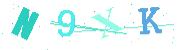

请输入验证码：N9XK


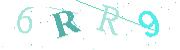

请输入验证码：6RR9
已完成285篇文献Thermally Stable and Regenerable PlatinumâTin Clusters for Propane Dehydrogenation Prepared by Atom Trapping on Ceria不支持HTML阅读
已完成286篇文献Thermally Stable and Regenerable PlatinumâTin Clusters for Propane Dehydrogenation Prepared by Atom Trapping on Ceria不支持HTML阅读
已完成287篇文献å¤çº§å­çº³ç±³ZSM-5åå­ç­èéä½çå¶å¤è°æ§åå¶æ­£åºç·å¬åè£è§£æ§è½ç ç©¶不支持HTML阅读
已完成289篇文献çç©è´¨ç­è§£æ¥åç©åä½è°è´¨åå¬åçç§ç¹æ§ç ç©¶不支持HTML阅读
已完成290篇文献å¬åè£è§£æºçå¯¼åçå¬ååè®¾è®¡åæ§è½不支持HTML阅读
已完成291篇文献å¤§åå­ç»æåæ°¢åä½ç´ åæçç­è§£æ¹æ³åå¶å¨å¡éæ¨çå°æ²¹æ°æå ä¸­çåºç¨ç ç©¶不支持HTML阅读
已完成292篇文献æ°®åéå¬åæ­£ä¸ç·æ°§åè±æ°¢å¶ç¯çç ç©¶不支持HTML阅读
已完成293篇文献çº³ç±³ZSM-5ç¢±è±ç¡æå»ºå¤å­ç»æåå¶MTHååºæ§è½ç ç©¶不支持HTML阅读
已完成294篇文献åå¶å°çå°åç¼åææ²¹ãè¡è´¨æ²¹ä¸ç¨ æ²¹çå½¢ææºç不支持HTML阅读
已完成295篇文献Oxidation)不支持HTML阅读
已完成296篇文献çç©è´¨å¶åè¯ç²éåè¯ç²é¸ä»¥ååæ

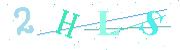

请输入验证码：2HLS
已完成348篇文献Assessment of solubility and viscosity of ultra-high molecular weight polymeric thickeners in ethane, propane and butane for miscible EOR不支持HTML阅读
已完成349篇文献æ±¡æ³¥å¬åç­è§£å¶åçç±»ååç©åè½¬åéå¾ç ç©¶不支持HTML阅读
已完成352篇文献ä¸»å®¢ä½ç¸äºä½ç¨çåºä½NMRç ç©¶不支持HTML阅读
已完成353篇文献Znè´è½½ZSM-5åå­ç­ä¸æ´»æ§ä¸­å¿ååä½ç¨çé«åºåºä½æ ¸ç£å±æ¯ç ç©¶不支持HTML阅读
已完成356篇文献çæ¥æºåæ不支持HTML阅读
已完成359篇文献æ°ç¥不支持HTML阅读
已完成361篇文献æ¹æ§ZSM-5åå­ç­å¬åç²éè³æåçç ç©¶不支持HTML阅读
已完成362篇

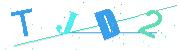

请输入验证码：TJD2
已完成365篇文献Influence of the state of Zn species over Zn-ZSM-5/ZSM-11 on the coupling effects of cofeeding n -butane with methanol不支持HTML阅读
已完成368篇文献ç²éè½¬åå¶ä¸ç¯åæ¸æ´æ±½æ²¹å¬ååçç ç©¶不支持HTML阅读
已完成369篇文献ç¯çææ¯ç ç©¶不支持HTML阅读
已完成371篇文献ç»åç ç©¶不支持HTML阅读
已完成372篇文献ä½é¶ç¤åå¶æ¶²åäº§ç©çåå­ç»æåæ不支持HTML阅读
已完成373篇文献ä½é¶ç¤çç©æå æ°ä¸ç­æå æ°æ¨¡æåå¶ç»ææ¼åç ç©¶不支持HTML阅读
已完成374篇文献è¾½è¥¿ä¸ç½å©ç»ä¹å¿ç»æ²ç§¯ææºè´¨åä½çç¢³âæ°¢åä½ç´ ç»æååé¢ååççæºä¸å¤æ°åç¯å¢æä¹不支持HTML阅读
已完成375篇文献ç¨äºç²éå¶ä¸ç¯ååºZSM-5åå­ç­çææå³ç³»ç ç©¶不支持HTML阅读
已完成376篇文献è±æ°¢å¶ç¯çå¬åååå·¥èºç ç©¶不支持HTML阅读
已完成377篇文献è±æ°¢å·¥èºåå¬ååç ç©¶不支持HTML阅读
已完成378篇文献è³æåå¬ååå¶å¤åå¶åºç¨不支持HTML阅读
已完成379篇文献æ©¡è¶é²æ¤è¡å¨NR/BRä¸­çåºç¨ç ç©¶不支持HTML阅读
已完成380篇文献ç¯çFe-Mgå¬ååçç ç©¶不支持HTML阅读
已完成381篇文献Dehydrogenation Catalysts.不支持HTML阅读
已完成382篇文献ä¸¤ç§ä½

已完成555篇文献è³æåå¬ååä¸çç ç©¶不支持HTML阅读
已完成556篇文献åé»æµ·ä¸­é¨æµ·åºæ²ç§¯ç©çç±»å°çåå­¦ç¹å¾åå¶æç¤ºæä¹不支持HTML阅读
已完成564篇文献FCCæ±½æ²¹å¬åè£è§£ååºçå®éªèå¯不支持HTML阅读
已完成567篇文献ç¯çå¬åååå·¥èºæ¡ä»¶çç ç©¶不支持HTML阅读
已完成568篇文献çæäº§ä¸å­不支持HTML阅读
已完成569篇文献NiO-æå¤éå±æ°§é¸çå¤åç©å¬ååå¨ä¸ç·ODHååºä¸­çå¬åæ§è½不支持HTML阅读
已完成570篇文献HZSM-5åå­ç­ä¸C6ï½8æ··åé¾çåé»äºç²è¯çå æ°¢è£å不支持HTML阅读
已完成571篇文献dehydrogenation over mesoporous Cr 2 O 3 /Al 2 O 3 catalysts不支持HTML阅读
已完成572篇文献oxidation over Ru supported on ZnAl 2 O 4 , CeO 2 and Al 2 O 3不支持HTML阅读
已完成573篇文献PtâSn-based catalyst's intensification using Al 2 O 3 âSAPO-34 as a support for propane dehydrogenation to propylene不支持HTML阅读
已完成574篇文献æ­£ä¸éæº¶æ¶²è¾åæ¾çµç­ç¦»å­ä½çµè§£ååºç¸äº§ç©ç ç©¶不支持HTML阅读
已完成575篇文献ç²éMTOä¸FCCæ±½æ²¹éç¯çç»åååºå·¥èºç ç©¶不支持HTML阅读
已完成576篇文献é»éªå³é·ä¸å¤ççç¢³é¸çå²©ä¸­åä½çç¢³åæ°¢å

已完成715篇文献åäº¬å¸å¤å­£å¤§æ°é¢ç²ç©ä¸­ææºæ±¡ææºççç©æ å¿ç©ç¤ºè¸ª不支持HTML阅读
已完成716篇文献åè½åå¬ååè®¾è®¡çæ¢ç´¢不支持HTML阅读
已完成720篇文献è³æåå¬ååçç å¶åå·¥èºææ¯ç ç©¶不支持HTML阅读
已完成723篇文献ç²éä½ä¸ºå¬åè£åé¨åè¿æçååºè¿ç¨ç ç©¶不支持HTML阅读
已完成724篇文献[bmim]Cl-AlCl3ç¦»å­æ¶²ä½å¯¹å¬åè£åæ±½æ²¹éç¯çæ§è½çç ç©¶不支持HTML阅读
已完成725篇文献Nano-sized crystallites of vanadyl pyrophosphate as a highly selective catalyst for n -butane oxidation不支持HTML阅读
已完成726篇文献éä½ä¹ç¯èåè£ç½®ç»¼åè½èçä¼åç»å不支持HTML阅读
已完成727篇文献ç¯çåå¶ååºæºççç ç©¶不支持HTML阅读
已完成734篇文献éæ©æ°§åä¸­çåºç¨不支持HTML阅读
已完成735篇文献ä½æ¸©ä¸ç²ç·ä¸ä¸ç·çå±åæ´»åè³æå不支持HTML阅读
已完成736篇文献å¬åè£è§£çç ç©¶不支持HTML阅读
已完成737篇文献æ´»åçå½±å不支持HTML阅读
已完成738篇文献Cr2O3-Al2O3ï¼ç¢³çº³ç±³ç®¡ï¼CNTsï¼å¬ååå¯¹C5è±æ°¢ä½ç¨ç ç©¶不支持HTML阅读
已完成739篇文献ç»æåè¿ç§»不支持HTML阅读
已完成740篇文献æ¹åéº»åç½å®¶å¡éåæåå±ä¸­çç±»èç©åå¸ç¹å¾å

已完成891篇文献ç²ç·æ æ°§è±æ°¢è³æåååºç ç©¶è¿å±不支持HTML阅读
已完成892篇文献ä¸äºæ°§åç¢³éæ´å¶åææ°(è±æ)不支持HTML阅读
已完成893篇文献ç(è±æ)不支持HTML阅读
已完成894篇文献å¤©ç¶æ°å¬åè½¬åæ°è¿å±不支持HTML阅读
已完成895篇文献K-Ni-La/Si-2å¬ååç¨äºå¤©ç¶æ°ä¸äºæ°§åç¢³éæ´å¶åææ°çç ç©¶不支持HTML阅读
已完成897篇文献ç²åºåä¸åºé(MTBE)çåæ不支持HTML阅读
已完成899篇文献ææ°ä¸å©不支持HTML阅读
已完成900篇文献éæ¹å¹é·éå®ç»ä½ççæºå²©é¥±åçç»æåå¶çæºæ¢è®¨不支持HTML阅读
已完成901篇文献åèèªé¸åå¸ç¹å¾不支持HTML阅读
已完成902篇文献å æ°´ç­è§£æ¡ä»¶ä¸ç¤æ­£æåä½çççæç¹å¾不支持HTML阅读
已完成903篇文献è½»çå¨Zn/ZSM-5ä¸çè³æå不支持HTML阅读
已完成904篇文献å¹¿é¥¶çç°ææºå°çåå­¦çåæ­¥ç ç©¶不支持HTML阅读
已完成905篇文献æ²¥éè´¨è±éçå°çåå­¦ç¹å¾åå¶æä¹不支持HTML阅读
已完成906篇文献ä¸ç·è±æ°¢å¶ä¸ç¯ç ç©¶è¿å±不支持HTML阅读
已完成907篇文献ä¸åç±»åæ²ç§¯ç©ä¸­èèªé¸çåå¸ãæ¼ååççæä¹不支持HTML阅读
已完成908篇文献çç©æ å¿ç©ç¹å¾åå¶ç­æ¼åè¯éªçåæ­¥ç ç©¶不支持HTML阅读
已完成909篇文献conversio

In [4]:
# 这一部分是下载论文内容，内容中包含大量垃圾信息

def check_vcode(driver):    # 检测并人工填写验证码
    try:   # 有的时候需要点击一下IP登录
        Button2 = driver.find_element_by_id("Button2")
        Button2.click()
        time.sleep(5)
        vcode = driver.find_element_by_id("vcode")   # 填写验证码
        vImg = driver.find_element_by_id("vImg")   # 验证码图片
        img_path = "./data/vImg.png"
        vImg.screenshot(img_path)
        img = Image.open(img_path)
        display(img)    # 展示图片
        input_string = input("请输入验证码：")
        vcode.send_keys(input_string + "\n")
        os.remove(img_path)
        time.sleep(5)
    except:
        pass
    

def get_content(thesis_url, driver, display_b):
    driver.get(thesis_url)
    check_vcode(driver)
    try:
        topTitle_d = driver.find_element_by_id("topTitle")
        topTitle = topTitle_d.get_attribute('textContent')
    except:
        # 如果进到这里，可能是因为操作太过频繁，需要重新登录
        try:
            driver.close()
            if display_b == 'n':
                # 下面这段代码是不让模拟浏览器显示出来的，测试完代码之后启动
                chrome_options = Options()
                chrome_options.add_argument('--headless')
                chrome_options.add_argument('--disable-gpu')
                driver = webdriver.Chrome(chrome_options = chrome_options)
            else:
                driver = webdriver.Chrome()
            driver.get(thesis_url)
            check_vcode(driver)
            topTitle = driver.find_element_by_id("topTitle").get_attribute('textContent')
        except:
            # 如果到了这一步，那没办法，只能跳过了
            return driver
        
    topTitle = '、'.join(topTitle.split('/'))
    content = driver.find_element_by_class_name("content").get_attribute('textContent')
    # content中包含大量无用信息，如需主要信息则需要进一步处理
    # 考虑到下一步是自然语言处理，故采用此方法
    with open("./thesis/{}.txt".format(topTitle.strip()), "wt", encoding = "utf-8") as fo:
        fo.write(content)
    return driver


def get_literature(url, driver, name, display_b):
    header = {
        "Host":"kns.cnki.net",
        "User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.54 Safari/537.36",
        "cookie":r"""Ecp_ClientId=2200624201703446328; RsPerPage=20; cnkiUserKey=6188a170-8f76-0ba1-7507-4e186c73d168; Ecp_ClientIp=219.217.157.44; x-s3-sid=>/lE28b``ugjwv6w/M1o38300; Ecp_loginuserbk=DB0060; style=lt; Hm_lvt_ba7af201fc75865e9846f701ccb53e6b=1619489343,1621435412; sensorsdata2015jssdkcross=%7B%22distinct_id%22%3A%221798514efd191a-040d5f445af37b-2363163-1327104-1798514efd235a%22%2C%22first_id%22%3A%22%22%2C%22props%22%3A%7B%7D%2C%22%24device_id%22%3A%221798514efd191a-040d5f445af37b-2363163-1327104-1798514efd235a%22%7D; UM_distinctid=17bfdc96f256bf-08aa53a9250a05-a7d173c-144000-17bfdc96f2641a; Hm_lvt_6e967eb120601ea41b9d312166416aa6=1632050471; ASP.NET_SessionId=slvsmlc1pzaagwjl3wxys3qw; SID_kns8=15123122; Ecp_session=1; SID_kns_new=kns123120; _pk_ref=%5B%22%22%2C%22%22%2C1632571144%2C%22https%3A%2F%2Fwww.baidu.com%2Flink%3Furl%3DVMp7DaDNu98VjlkMPcIqu_Pt69OCg-Ce2Y1cyzS5VK_%26ck%3D805.0.213.158.152.NaN.NaN.0NaN.NaN.0%26shh%3Dwww.baidu.com%26sht%3D50000021_hao_pg%26wd%3D%26eqid%3D99ede8bf0012a9f4000000045ef3444e%22%5D; CurrSortField=%e5%8f%91%e8%a1%a8%e6%97%b6%e9%97%b4%2f(%e5%8f%91%e8%a1%a8%e6%97%b6%e9%97%b4%2c%27TIME%27); CurrSortFieldType=desc; SID_kcms=124114; yeswholedownload=%3Bsxjg202105022; _pk_id=03f8ea77-e542-4922-b42d-4b34026aed98.1607761093.26.1632572878.1632571144.; c_m_expire=2021-09-25 21:18:17; c_m_LinID=LinID=WEEvREcwSlJHSldSdmVpa3VEOHV2V3dHOUYweGZWS2YrTHIzNm9DTXN3bz0=$9A4hF_YAuvQ5obgVAqNKPCYcEjKensW4IQMovwHtwkF4VYPoHbKxJw!!&ot=09/25/2021 21:18:17; LID=WEEvREcwSlJHSldSdmVpa3VEOHV2V3dHOUYweGZWS2YrTHIzNm9DTXN3bz0=$9A4hF_YAuvQ5obgVAqNKPCYcEjKensW4IQMovwHtwkF4VYPoHbKxJw!!; Ecp_LoginStuts={"IsAutoLogin":false,"UserName":"DB0060","ShowName":"%E5%A4%A7%E8%BF%9E%E7%90%86%E5%B7%A5%E5%A4%A7%E5%AD%A6%E5%9B%BE%E4%B9%A6%E9%A6%86","UserType":"bk","BUserName":"","BShowName":"","BUserType":"","r":"hHcCCA"}"""
    }
    r = requests.get(url, headers = header)
    r.encoding = r.apparent_encoding
    soup = bs(r.text, "html.parser")
    li = soup.find("li", {"class":"btn-html"})
    if li == None or li.find('a') == None:
        print("文献{}不支持HTML阅读".format(name.encode('utf-8').decode('unicode_escape')))
        return driver
    thesis_url = "https:" + li.find('a').attrs["href"]
    driver = get_content(thesis_url, driver, display_b)
    return driver


def main():
    start = time.time()
    url_form = """https://kns.cnki.net/kcms/detail/detail.aspx?dbcode={}&dbname={}\
        &filename={}&uniplatform=NZKPT"""   # 这个是网址的填写模板
    display_b = input("是否显示模拟浏览器？(y/n)")
    if display_b == 'n':
        # 下面这段代码是不让模拟浏览器显示出来的，测试完代码之后启动
        chrome_options = Options()
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--disable-gpu')
        driver = webdriver.Chrome(chrome_options = chrome_options)
    else:
        driver = webdriver.Chrome()
        # driver放在这里是为了在后面少输入几次验证码，即只打开一次模拟浏览器
    with open("./data/info_ls.json", 'rt', encoding = 'utf-8') as fi:
        i = 0
        for thesis in fi:
            thesis = json.loads(thesis.strip())
            thesis_name = thesis['name'].encode('utf-8').decode('unicode_escape').strip()
            thesis_path = "./thesis/{}.txt".format('、'.join(thesis_name.split('/')))
            if os.path.exists(thesis_path):
                continue   # 如果要爬的文献已经下载了，就跳过
            url = thesis['url']
            if "RedirectScholar" not in url:
                for tiankong in url.split('/')[-1].split('&'):
                    if "DbCode" in tiankong:
                        dbcode = tiankong.split('=')[-1]
                    elif "DbName" in tiankong:
                        dbname = tiankong.split('=')[-1]
                    elif "FileName" in tiankong:
                        filename = tiankong.split('=')[-1]
                url = url_form.format(dbcode, dbname, filename)
            driver = get_literature(url, driver, thesis['name'], display_b)
            print("\r已完成{}篇".format(thesis['seq']), end = '')
    driver.close()
    print("\r文献下载完毕，耗时：{}s".format(time.time() - start))
    
    
main()